## This is a FSI problem of 2D airfoil active-oscillating in flow with gravity

### Strouhal number St=0.08, non-dimensional flapping amplitude Ad=1.4, Re=1000 for 2P wake. Modify St, Ad and Re would produce different wake forms inclduing 2S, 2P, 2S+2P, 4P, 4P+2S etc.

In [3]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
default(grid = false)

In [1]:
using Pkg
Pkg.activate("..")
using FSInteraction

In [3]:
filename = "Airfoil_2P";

## <span style="color:blue"> Domain grid points number

In [4]:
nx = 202; ny = 502;
Ly = 10.0;
Δx = Ly/(ny-2);

## <span style="color:blue"> Set up rigid body with Dyn3d.jl

#### System parameters

In [5]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

ConfigSystem(2, [0.0, 0.0, -1.0], NumParams(1.0, 0.001, "Liska", 3, 0.0001))

#### Airfoil shape function

In [6]:
function airfoil(z₀::Vector{Float64}, D::Float64, C::Float64, n1::Int, n2::Int, n3::Int)
    # z₀ for half-circle center location
    # D for half-circle diameter
    # C for total length of the airfoil
    # n1 for number of points on airfoil top half-circle
    # n2 for number of points on airfoil left boundary
    # n3 for number of points on airfoil right boundary
    # Δx for space between every two points
    
    r = D/2
    Δx = (π*D/2 + 2*sqrt((D/2)^2+(C-D/2)^2))/(n1+n2+n3)
    verts = zeros(n1+n2+n3,2)
    
    # top half-circle
    for i = 1:n1+1
        verts[i,1] = r*cos(π/(n1-1)*(i-1)) + z₀[1]
        verts[i,2] =r*sin(π/(n1-1)*(i-1)) + z₀[2]
    end
    
    # left boundary
    θ = atan(D/2/(C-D/2))
    l = sqrt((D/2)^2+(C-D/2)^2)
    for i = 1:n2-1
        verts[i+n1,1] = z₀[1] - D/2 + Δx*i*sin(θ)
        verts[i+n1,2] = z₀[2] - Δx*i*cos(θ)
    end
    
    # central lower point
    verts[n1+n2,1] = z₀[1]
    verts[n1+n2,2] = z₀[2] - (C-D/2)
    
    # right boundary
    for i = 1:n3
        verts[i+n1+n2,1] = z₀[1] + D/2 - Δx*i*sin(θ)
        verts[i+n1+n2,2] = z₀[2] - Δx*i*cos(θ)
    end  
    
    return verts
end

airfoil (generic function with 1 method)

#### Set up body

In [7]:
# find out number of points on the airfoil
D = 0.2
C = 1.2
n1 = round(Int,π*D/2/Δx) + 1 # airfoil top half-circle
n2 = round(Int,sqrt((D/2)^2+(C-D/2)^2)/Δx) - 1 # airfoil left boundary
n3 = round(Int,sqrt((D/2)^2+(C-D/2)^2)/Δx) - 2 # airfoil right boundary
nverts = n1+n2+n3

verts = airfoil([0.,0.], D, C, n1, n2, n3)
nbody = 1
config_body = ConfigBody(nbody, nverts, verts, 2.0)
config_bodys = fill(config_body, nbody);

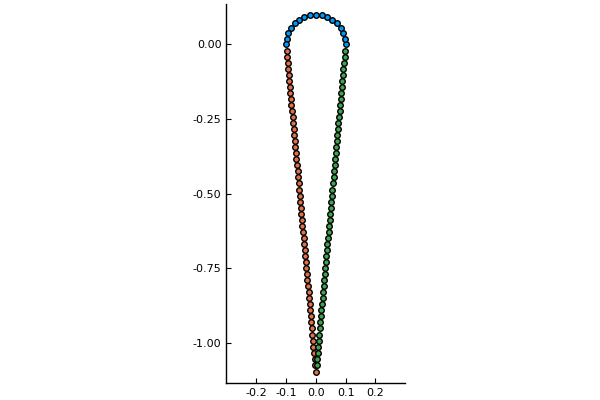

In [8]:
p = scatter(verts[1:n1,1], verts[1:n1,2],ratio=1,legend=false,xlim=(-0.3,0.3))
scatter!(p,verts[n1+1:n1+n2,1], verts[n1+1:n1+n2,2])
scatter!(p,verts[n1+n2+1:n1+n2+n3,1], verts[n1+n2+1:n1+n2+n3,2])

#### Set up joints

In [9]:
St_D = 0.08
A_D = 1.4
f = St_D/D
A = A_D*D/2;

In [10]:
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the active joint with no stiff and damp
motion = Motions("oscillatory", [A, f, 0.0])
dof = Dof(2, "active", 0., 0., motion)
config_joints[1] = ConfigJoint(njoint, "custom_revolute_in_y",
    [0.0,-π/2,0.0,2.0,0.0,9.5], zeros(Float64,6), 0, [dof], [0.0])

 joint type = custom_revolute_in_y
 joint position in parent body coord = [0.0, -1.5708, 0.0, 2.0, 0.0, 9.5]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 2, under active oscillatory motion
 initial unconstrained dof position = [0.0]
 initial unconstrained dof velocity = [0.0]


#### Build joint-body chain

In [11]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [12]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [13]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [14]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

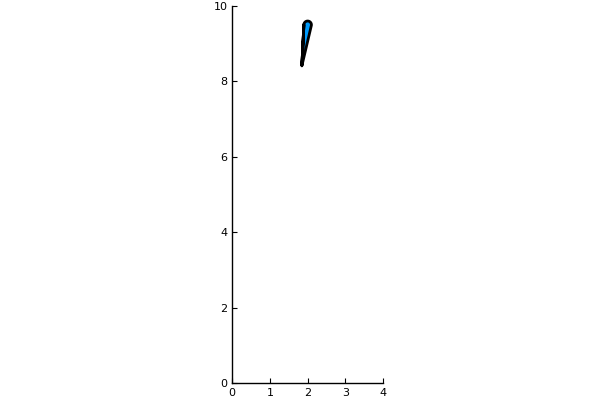

In [15]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,4), ylims=(0,10),ratio=1,legend=false)

## <span style="color:blue"> Set up fluid with ViscousFlow.jl</span>

#### Set the flow parameters

In [16]:
Re = 1000 # Reynolds number
U = -1.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, -1.0)

#### Set the domain grid

In [17]:
Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:10.01)

#### Set up fluid initial conditions

In [18]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [19]:
plane = [1,3];

#### Genrate body grid points and get linear velocity on them

In [20]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [21]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [22]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [23]:
tf = 3000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2;

## <span style="color:blue"> Create ifherk object </span>

In [24]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSInteraction.r₁(w,t,fsys), bd -> F(bd,config_body.ρ), w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=2, ρb=config_body.ρ)

 30.415119 seconds (50.52 M allocations: 6.105 GiB, 3.73% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [25]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [ ]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
end

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [28]:
contour_levels = range(-10*Δx,stop=10*Δx,length=40)
sample_freq = 5
clims = (-5*Δx,5*Δx)
fps = 25;

#### Get body verts history

In [44]:
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end
fb = [1:nverts;1];

#### Plot first and last time field

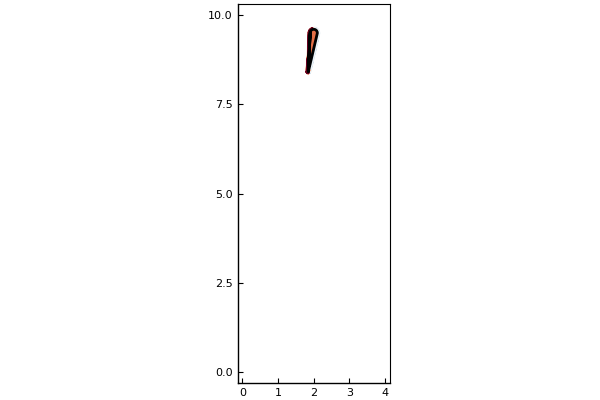

In [45]:
p = plot(xg,yg,whist[1],levels=contour_levels,clims=clims,color=:RdBu_10)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

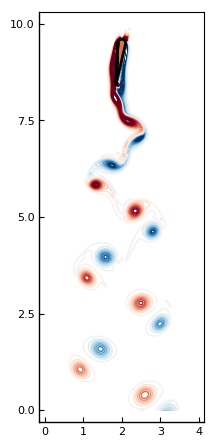

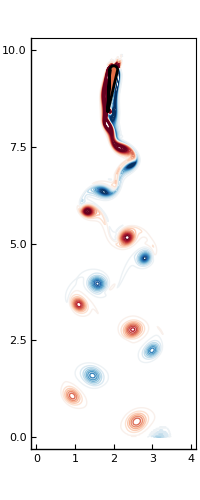

In [62]:
p = plot(xg,yg,whist[end],levels=contour_levels,clims=clims,color=:RdBu_10)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,filename*".eps")
p

#### Make gif

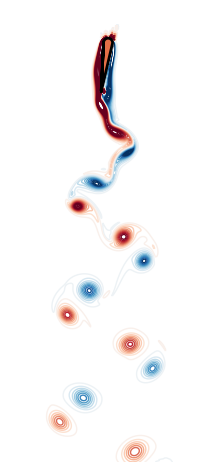

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/thesis/airfoil vortex shedding/Airfoil_003.gif
└ @ Plots /home/fs/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/thesis/airfoil vortex shedding/Airfoil_003.gif")
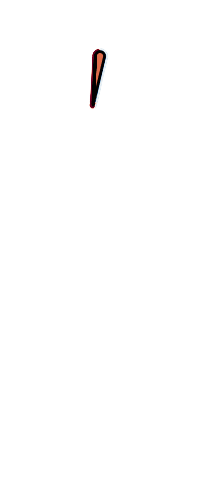

In [30]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,clims=clims,size=(200,500),ylim=(0.2,10.2),framestyle=:none,color=:RdBu_10)
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,1], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black",fill=true)
    end
end

gif(anim, filename*".gif", fps = fps)

#### tail trajectory

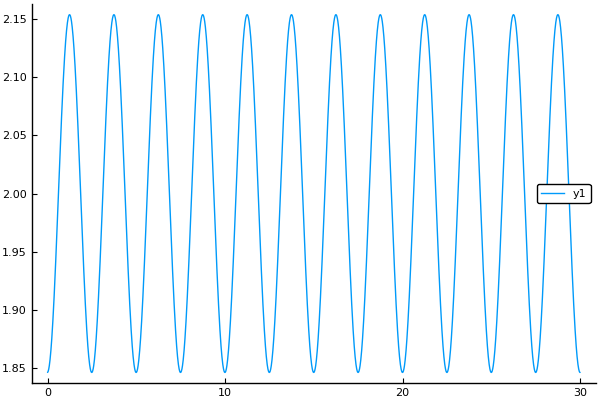

In [48]:
p1hist = []

for i in 1:length(bdhist)
    push!(p1hist,bdhist[i].bs[1].verts_i[n1+n2,1])    
end

plot(thist,p1hist)

## <span style="color:blue"> Save Data </span>

#### Save all current data .bson file

In [54]:
# whist_1 = whist[1:1500]
# whist_2 = whist[1501:3000]

# @save filename*"_whist_1.bson" whist_1
# @save filename*"_whist_2.bson" whist_2
# @save filename*"_else.bson" bd bdhist xg yg vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [26]:
# using Dyn3d
# using ViscousFlow

# @load filename*"_whist_1.bson" whist_1
# @load filename*"_whist_2.bson" whist_2
# @load filename*"_else.bson" bd bdhist xg yg vshist thist fx fy Δt w qJ v t f

# @get bd (bs,js,sys);

In [27]:
# whist = deepcopy(whist_1)
# append!(whist,whist_2)

# fb = [1:124;1];
# plane = [1,3];